# 1. Load The Libraries : 

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog

# 2. Read The Images Path: 

In step 2, all the path for the the images were read and I create a dataframe with two columns which are : 1. path 2.label

In [2]:
path = 'D:/other/python/IMT/Breast Cancer/Breast-Cancer/Data'

categories = [['benign',438],['malignant',211],['normal',134]]

images_path_list= []
mask_path_list = []

all_data_path_list = []


for i in range(len(categories)) : 
    
    folder_path = (f'{path}/{categories[i][0]}')
    
    for j in range(1,categories[i][1]):
    
        image_path = (f'{folder_path}/{categories[i][0]} ({j}).png') 
        mask_path = (f'{folder_path}/{categories[i][0]} ({j})_mask.png') 
        
        images_path_list.append(image_path)
        mask_path_list.append(mask_path)
        
    data_path_df = pd.DataFrame()
    
    data_path_df['Image-Path'] =   images_path_list   
    data_path_df['Mask-Path'] = mask_path_list
    data_path_df['Label'] = categories[i][0]
    
    all_data_path_list.append(data_path_df)
    
    images_path_list = []
    mask_path_list = []
    
data_path_df = pd.concat(all_data_path_list,axis = 0)
data_path_df.reset_index(drop=True,inplace=True)
        
data_path_df.to_csv('D:/other/python/IMT/Breast Cancer/Breast-Cancer/Data/path.csv')
data_path_df

,Image-Path,Mask-Path,Label
0,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,benign
1,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,benign
2,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,benign
3,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,benign
4,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,benign
...,...,...,...
775,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,normal
776,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,normal
777,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,normal
778,D:/other/python/IMT/Breast Cancer/Breast-Cance...,D:/other/python/IMT/Breast Cancer/Breast-Cance...,normal


# 3. Shuffle Dataset : 

I notice that there is imbalance in dataset, because the number of the avalaible samples for each label in not the same, so I decided to consider the value 133 for each label that in the minimum number of the sample for lables.

Then, I shuffle all dataset, because the pathes were inported in order, so I shuffle them.


In [3]:
benign_df = data_path_df.iloc[0:133,:]

malignant_df = data_path_df.iloc[437:646,:]

normal_df = data_path_df.iloc[647:780,:]

shuffled_benign_df = benign_df.sample(133)

shuffled_malignant_df = malignant_df.sample(133)

final_df = pd.concat([shuffled_benign_df,shuffled_malignant_df,normal_df],axis=0)

final_df.reset_index(drop=True,inplace=True)

final_df

map_dic = {'benign':0,'malignant':1,'normal':2}
final_df.replace(map_dic,inplace=True)

final_df['Label'].value_counts()

C:\Users\sina tavakoli\AppData\Local\Temp\ipykernel_13156\3456478526.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.replace(map_dic,inplace=True)


Label
0    133
1    133
2    133
Name: count, dtype: int64

# 4. Read The Images & Masks : 

In step 4, I read the images from the pathes and also resize them, bvecause I need to be in the same size to generate a vector in the same size and then spilit data to the training and test to feed the model.

In [4]:
def load_images_and_mask(image_path,mask_path,target_size = (400,400)) : 
    
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image,target_size)
    mask = cv2.resize(mask,target_size)
    
    return image,mask


# 6. Extract HOG Features : 

In [5]:
def hog_extractor(image,mask) : 
    
    masked_image = cv2.bitwise_and(image,image,mask=mask)
    
    gray_image = cv2.cvtColor(masked_image,cv2.COLOR_BGR2GRAY)
    
    features,hot_image = hog(gray_image,pixels_per_cell=(16,16),cells_per_block=(2,2),visualize=True)
    
    return features
    

# 7. Preparing Dataset For Training :  

In [6]:
X = []
Y = []

for rows in range(len(final_df)) : 
    
    image_path = final_df.loc[rows,'Image-Path']
    
    mask_path = final_df.loc[rows,'Mask-Path']
    
    image,mask = load_images_and_mask(image_path=image_path,mask_path=mask_path)
    
    features = hog_extractor(image=image,mask=mask)
    
    X.append(features)
    
    Y.append(final_df.loc[rows,'Label'])

X = np.array(X)
Y = np.array(Y)    
    
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)    
    
    

# 8. Decision Tree Model Function : 

finally I define a function to create the final model and calculate the final accuracy with the respect to the different attributes that are avalaible in Decision Tree model in skeat learn and save the final result.

In [7]:
def decision_tree_model():
    
    grid = {
        
        'criterion' : ["gini", "entropy"],
        'max_depth' : [1,2,3,4,5,6,7,8,9,10],
        }
    
    estimator = DecisionTreeClassifier()
    
    cv_model = GridSearchCV(estimator=estimator,param_grid=grid,cv=5)
    
    cv_model.fit(X=X_train,y=Y_train.ravel())
    
    print(f'\nThe best parameters are : {cv_model.best_params_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe train accuracy is equal to : {cv_model.best_score_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe test accuracy is equal to : {cv_model.score(X=X_test,y=Y_test)}\n------------------------------------------------------------------------------\n')
    
    return cv_model.best_estimator_
    
    
    

# 9. Decision Tree Model : 

In [8]:
DecisionTree_Model = decision_tree_model()
Y_prediction_DTM = DecisionTree_Model.predict(X_test)


The best parameters are : {'criterion': 'gini', 'max_depth': 7}
------------------------------------------------------------------------------


The train accuracy is equal to : 0.7553571428571428
------------------------------------------------------------------------------


The test accuracy is equal to : 0.725
------------------------------------------------------------------------------



# 10. Define A Function To Evalute The Model : 

In [9]:
def evaluate(Y_prediction,name):
    
    report = classification_report(y_true=Y_test,y_pred=Y_prediction)
    
    print(report)
    
    print('\n---------------------------------------------------------------------------------------------------------------\n')
    
    conf_matrix = confusion_matrix(y_true=Y_test,y_pred=Y_prediction)
    
    plt.figure(figsize=(8,5))
    
    sns.heatmap(conf_matrix,annot=True,cmap='Blues')
    
    plt.xlabel('Predicted Label')
    
    plt.ylabel('True Label')
    
    plt.title(f'{name} Evaluation')
    
    plt.show()

# 11. Evaluate Decision Tree Model : 

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        29
           1       0.83      0.58      0.68        26
           2       0.68      1.00      0.81        25

    accuracy                           0.72        80
   macro avg       0.74      0.73      0.72        80
weighted avg       0.74      0.72      0.72        80


---------------------------------------------------------------------------------------------------------------



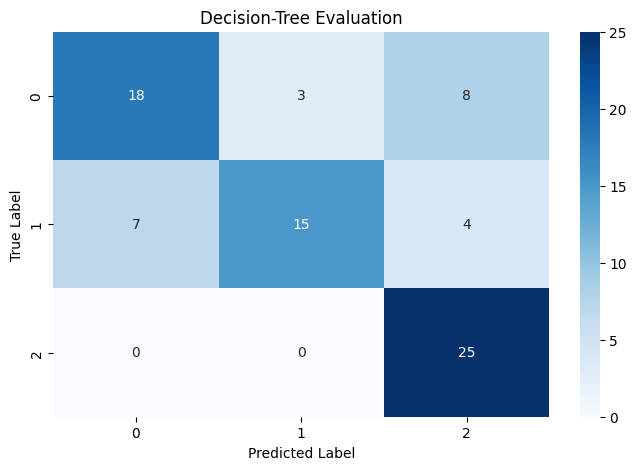

In [10]:
evaluate(Y_prediction=Y_prediction_DTM,name='Decision-Tree')

# 12. Random Forest Model Function : 

In [11]:
def random_forest():
    
    grid = {
        
        'n_estimators' : [10,20,30,40,50,60,70,80,90,100],
        'criterion' : ["gini", "entropy"],
        'max_depth': [1,2,3,4,5,6,7,8,9,10],
        
        }
    
    estimator = RandomForestClassifier()
    
    cv_model = GridSearchCV(estimator=estimator,param_grid=grid,cv=5)
    
    cv_model.fit(X=X_train,y=Y_train.ravel())
    
    print(f'\nThe best parameters are : {cv_model.best_params_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe train accuracy is equal to : {cv_model.best_score_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe test accuracy is equal to : {cv_model.score(X=X_test,y=Y_test)}\n------------------------------------------------------------------------------\n')
    
    return cv_model.best_estimator_
    
    
    

# 10. Random Forest Model :

In [12]:
RandomForest_Model = random_forest()
Y_prediction_RFM = RandomForest_Model.predict(X_test)


The best parameters are : {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
------------------------------------------------------------------------------


The train accuracy is equal to : 0.7961805555555556
------------------------------------------------------------------------------


The test accuracy is equal to : 0.7875
------------------------------------------------------------------------------



# 11. Evaluate Random Forest Model : 

In [ ]:
evaluate(Y_prediction=Y_prediction_RFM,name='Random-Forest')

# 12. SVM Model Function : 

In [ ]:
def SVM():    
    grid = {
        'C' : [0.01,0.1,1,10],
        
        'kernel' : ["linear","poly","rbf",'sigmoid'],
        
        'degree' : [3,5,7],
        
        'gamma' : [0.01,0.1,1]
    }

    SVM_Model = SVC()

    SVM_CV = GridSearchCV(estimator=SVM_Model,param_grid=grid,cv=5)

    SVM_CV.fit(X=X_train,y=Y_train.ravel())

    print(f'\nThe best parameters are : {SVM_CV.best_params_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe train accuracy is equal to : {SVM_CV.best_score_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe test accuracy is equal to : {SVM_CV.score(X=X_test,y=Y_test)}\n------------------------------------------------------------------------------\n')
    
    return SVM_CV.best_estimator_

# 13. SVM Model : 

In [ ]:
SVM_Model = SVM()
Y_prediction_SVM = SVM_Model.predict(X_test)

# 14. Evaluate SVM Model : 

In [ ]:
evaluate(Y_prediction=Y_prediction_SVM,name='SVM')